In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 4.1 Monte-Carlo Sampling

$$ \int_{0}^{\pi} \frac{dx}{x^2 + \cos(x)^2}$$

In [2]:
def func(x):
    return 1/(np.power(x, 2) + np.power(np.cos(x), 2))

In [3]:
import scipy.integrate as integrate
import scipy.special as special
x = np.linspace(0, np.pi, 10000)
result = integrate.quad(func, 0, np.pi)
print(result)

(1.5811879708477277, 1.2372872371839774e-10)


approximated result: 1.5811879708477277

### a)

In [4]:
samples = np.random.uniform(0, np.pi, 100)
integral = np.mean([func(i) for i in samples])*np.pi

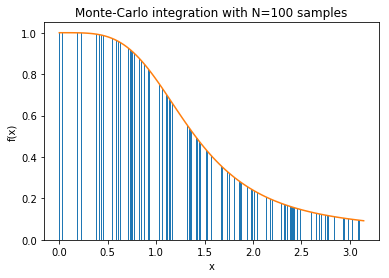

Estimated integral value: 1.522457616488706


In [5]:
x = np.linspace(0, np.pi, 100)
plt.plot(x, func(x), c='C1')
plt.bar(samples, func(samples), width=0.01)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Monte-Carlo integration with N=100 samples')
plt.show()
print('Estimated integral value:',integral)

### b)

In [16]:
def mc_sampling(N, p):
    for i in range(len(N)):
        samples = np.random.uniform(0, np.pi, N[i])
        integral = np.mean([func(i) * p(x) for i in samples])*np.pi
        diff = [(func(i) - np.mean(func(samples))**2) for i in samples]
        variance = np.sum(diff)/(N[i]-1)
        plt.plot(samples, func(samples), '.')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('N={0}'.format(N[i]))
        plt.show()
        print('Estimated integral:', integral)
        print('Error:', np.abs(result[0]-integral)*100, '%')
        print('Variance: ', variance)

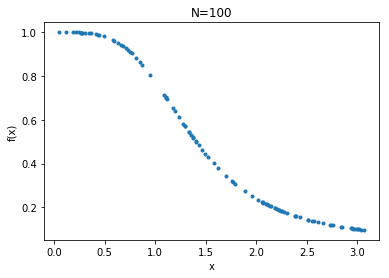

Estimated integral value: 1.534316549543772
Error: 4.687142130395561 %
Variance:  0.25238905493750957


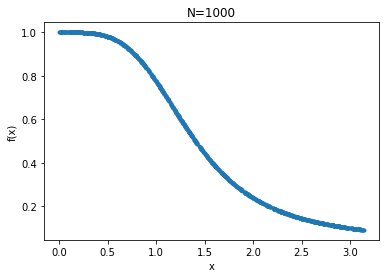

Estimated integral value: 1.5810547656771352
Error: 0.013320517059245418 %
Variance:  0.25023957698464316


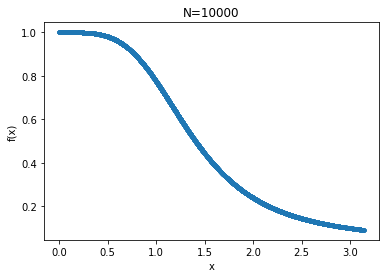

Estimated integral value: 1.571359689643404
Error: 0.9828281204323774 %
Variance:  0.25002497033994975


In [7]:
def p1(x):
    return 1
mc_sampling([100, 1000, 10000], p1)

### c)

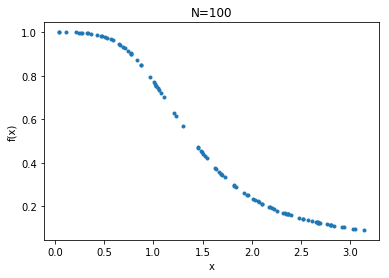

Estimated integral value: 0.4691275776861928
Error: 111.2060393161535 %
Variance:  0.25234941785986725


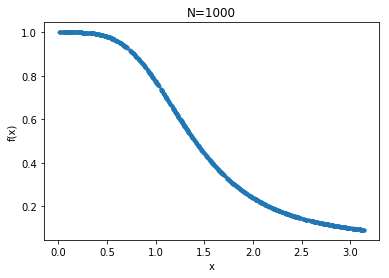

Estimated integral value: 0.4863916349145569
Error: 109.47963359331708 %
Variance:  0.2502279416282379


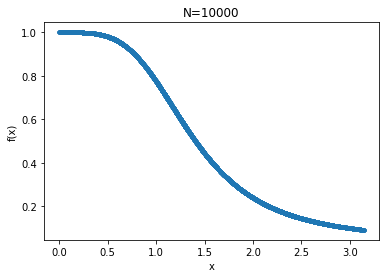

Estimated integral value: 0.48453546655927676
Error: 109.6652504288451 %
Variance:  0.2500171912484867


In [8]:
def p2(x):
    return np.exp(-x)
mc_sampling([100, 1000, 10000], p2)

### 4.2 Markov Chain Monte-Carlo

In [9]:
class MCMC:
    def __init__(self, parameters, method='mc'):
        self.k = parameters['k']
        self.a = parameters['a']
        self.K = parameters['K']
        self.kbT = parameters['kbT']
        self.method = method
        self.pos, self.energy = None, None
    
    def __mc_step(self, pos, energy):
        pos_trial = pos + (np.random.rand(*pos.shape) - 0.5)*self.a
        energy_trial = self.pot(pos_trial[0], pos_trial[1])

        if np.random.rand() <= np.exp(-(energy - energy_trial)/self.kbT):
            return pos_trial, energy_trial
        return pos, energy
    
    def __hastings_step(self, pos, energy):
        pos_trial = pos + (np.random.uniform(-0.5, 0.5, 2))*self.a
        energy_trial = self.pot(pos_trial[0], pos_trial[1])

        if np.random.rand() <= np.min([1, np.exp(-self.kbT*(energy_trial - energy))]):
            return pos_trial, energy_trial
        return pos, energy

    def pot(self, x, y):
        return (-self.K*(x**2 + y**2)/2) + (self.k*((np.abs(x - y) - self.a)**2)/2)
    
    def markov_chain(self, init_pos, N):
        pos = [init_pos, ]
        energy = [self.pot(init_pos[0], init_pos[1]), ]

        for i in range(N):
            if self.method=='mc':
                pos_, energy_ = self.__mc_step(pos[-1], energy[-1])
            elif self.method=='hastings':
                pos_, energy_ = self.__hastings_step(pos[-1], energy[-1])
            pos.append(pos_)
            energy.append(energy_)

        self.pos = np.asarray(pos)
        self.energy = np.asarray(energy)
        return self.pos, self.energy
    
    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10, 5))
        ax[0].plot(*self.pos[:100].T, '--', color='grey')
        ax[0].scatter(*self.pos[:100].T, c=self.energy[:100])
        ax[0].set_title('Random walk in first 100 step')
        ax[1].hist2d(*self.pos.T,  bins=100)
        ax[1].set_title('2D histogram of positions')

In [10]:
parameters1 = {
    'k': 0,
    'a': 0.5, #nm
    'K': 1, #pN/nm
    'kbT': 4 #pN*nm
}

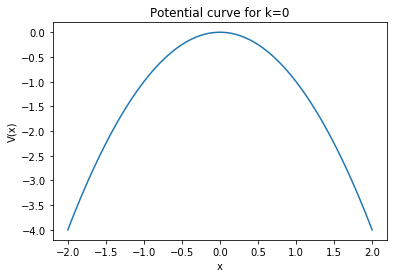

In [20]:
mc1 = MCMC(parameters1, method='mc')
x = np.linspace(-2, 2, 101)
xy = np.vstack((x, x)).T
plt.title('Potential curve for k=0')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.plot(x, mc1.pot(xy[:,0], xy[:,1]))

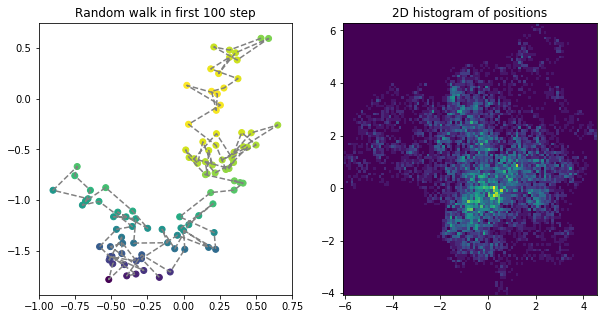

In [12]:
init_pos = np.random.random(2)
mc1_pos, mc1_energy = mc1.markov_chain(init_pos, 10000)
mc1.plot()

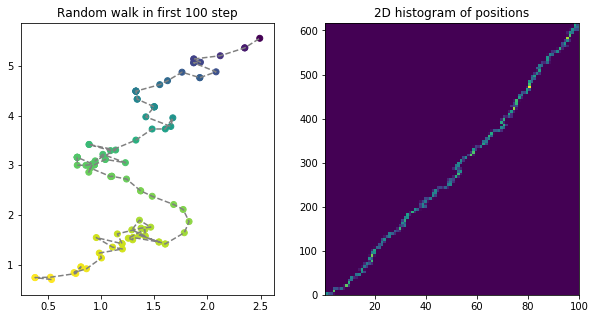

In [13]:
init_pos = np.random.random(2)
hastings1 = MCMC(parameters1, method='hastings')
hastings1_pos, hastings1_energy = hastings1.markov_chain(init_pos, 10000)
hastings1.plot()

Text(0,0.5,'V(x)')

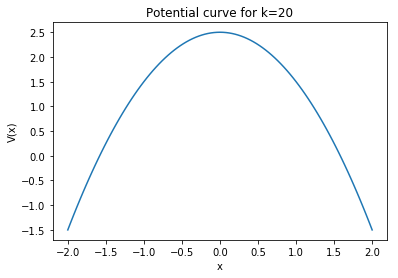

In [22]:
parameters2 = {
    'k': 20,
    'a': 0.5, #nm
    'K': 1, #pN/nm
    'kbT': 4 #pN*nm
}

mc2 =  MCMC(parameters2)

plt.plot(x, mc2.pot(xy[:,0], xy[:,1]))
plt.title('Potential curve for k=20')
plt.xlabel('x')
plt.ylabel('V(x)')

/Users/evabertalan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


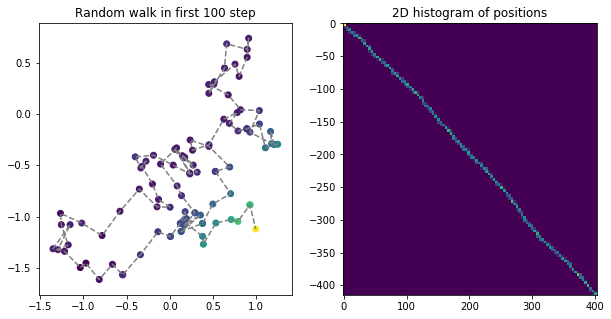

In [23]:
init_pos = np.random.random(2)
mc2_pos, mc2_energy = mc2.markov_chain(init_pos, 10000)
mc2.plot()

/Users/evabertalan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


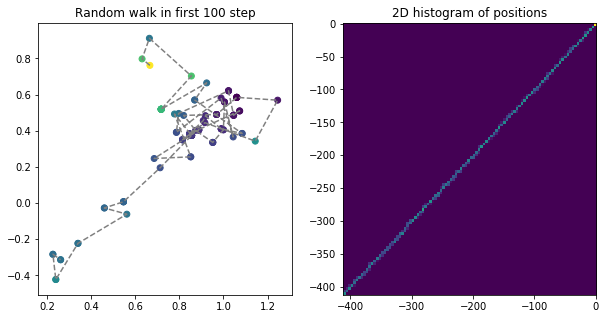

In [15]:
init_pos = np.random.random(2)
hastings2 = MCMC(parameters2, method='hastings')
hastings2_pos, hastings2_energy = hastings2.markov_chain(init_pos, 10000)
hastings2.plot()

### TODO:
* check variance
* trial position calculation is self.a needed?
* acceptance probability calculation in both case